## Gathering

In [1]:
import pandas as pd
import json
import requests
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

# load twitter_archive_enhanced into a dataframe,tae stands for twitter archive enhanced
tae=pd.read_csv('twitter-archive-enhanced.csv')
url = 'https://raw.githubusercontent.com/udacity/new-dand-advanced-china/master/数据清洗/WeRateDogs项目/image-predictions.tsv'
response = requests.get(url)

#open a file called image-predictions.tsv, and write response in this file
with open(url.split('/')[-1],mode='wb') as file:
    file.write(response.content)
    
# ip stands for image prediction
ip = pd.read_csv('image-predictions.tsv',sep='\t')
tweet_json = []

#read tweet_json file, and put content in a dataframe
with open('tweet_json.txt', 'r') as f:
    for line in f.readlines():
        x = json.loads(line)
        tweet_id=x['id']
        retweet_count = x['retweet_count']
        favorite_count = x['favorite_count']
        tweet_json.append({'tweet_id':tweet_id,
                          'retweet_count':retweet_count,
                          'favorite_count':favorite_count})
print(tweet_json)
# turn into a dataframe
tweet = pd.DataFrame(tweet_json, columns=['tweet_id','retweet_count','favorite_count'])


[{'tweet_id': 892420643555336193, 'retweet_count': 8842, 'favorite_count': 39492}, {'tweet_id': 892177421306343426, 'retweet_count': 6480, 'favorite_count': 33786}, {'tweet_id': 891815181378084864, 'retweet_count': 4301, 'favorite_count': 25445}, {'tweet_id': 891689557279858688, 'retweet_count': 8925, 'favorite_count': 42863}, {'tweet_id': 891327558926688256, 'retweet_count': 9721, 'favorite_count': 41016}, {'tweet_id': 891087950875897856, 'retweet_count': 3240, 'favorite_count': 20548}, {'tweet_id': 890971913173991426, 'retweet_count': 2142, 'favorite_count': 12053}, {'tweet_id': 890729181411237888, 'retweet_count': 19548, 'favorite_count': 66596}, {'tweet_id': 890609185150312448, 'retweet_count': 4403, 'favorite_count': 28187}, {'tweet_id': 890240255349198849, 'retweet_count': 7684, 'favorite_count': 32467}, {'tweet_id': 890006608113172480, 'retweet_count': 7584, 'favorite_count': 31127}, {'tweet_id': 889880896479866881, 'retweet_count': 5116, 'favorite_count': 28208}, {'tweet_id': 8

## Assessing

#### Assessing Twitter archive enhanced

In [78]:
tae.info() # 181 retweet_id
tae.sample(20)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1168,721001180231503872,NaN,NaN,2016-04-15 15:44:11 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Oliver. Bath time is upon him. His fea...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/721001180...,11,10,Oliver,None,None,pupper,None
1039,744234799360020481,NaN,NaN,2016-06-18 18:26:18 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here's a doggo realizing you can stand in a po...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/744234799...,13,10,None,doggo,None,None,None
418,822462944365645825,NaN,NaN,2017-01-20 15:17:01 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Gabe. He was the unequivocal embodimen...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/822462944...,14,10,Gabe,None,None,pupper,None
1291,708119489313951744,NaN,NaN,2016-03-11 02:36:57 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cooper. He basks in the glory of rebel...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/708119489...,9,10,Cooper,None,None,None,None
435,820446719150292993,NaN,NaN,2017-01-15 01:45:15 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Peaches. She's the ulti...,8.001414e+17,4.196984e+09,2016-11-20 00:59:15 +0000,https://twitter.com/dog_rates/status/800141422...,13,10,Peaches,None,None,None,None
878,760656994973933572,NaN,NaN,2016-08-03 02:02:14 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Rose. Her face is stuck like that. 11/...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/760656994...,11,10,Rose,None,None,None,None
632,793962221541933056,NaN,NaN,2016-11-02 23:45:19 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Maximus. His face is stuck like that. ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/793962221...,12,10,Maximus,None,None,None,None
276,840632337062862849,NaN,NaN,2017-03-11 18:35:42 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Say hello to Maddie and Gunner. They are consi...,NaN,NaN,NaN,"https://www.gofundme.com/3hgsuu0,https://twitt...",12,10,Maddie,None,None,None,None
1664,682788441537560576,NaN,NaN,2016-01-01 05:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Happy New Year from your fav holiday squad! 🎉 ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/682788441...,12,10,None,None,None,pupper,None
618,796177847564038144,NaN,NaN,2016-11-09 02:29:25 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Ruby. She just turned o...,7.961497e+17,4.196984e+09,2016-11-09 00:37:46 +0000,https://twitter.com/dog_rates/status/796149749...,11,10,Ruby,None,None,None,None


In [79]:
tae['name'].value_counts()

None         745
a             55
Charlie       12
Cooper        11
Lucy          11
Oliver        11
Tucker        10
Penny         10
Lola          10
Winston        9
Bo             9
Sadie          8
the            8
Bailey         7
an             7
Buddy          7
Daisy          7
Toby           7
Jack           6
Koda           6
Dave           6
Scout          6
Oscar          6
Jax            6
Rusty          6
Bella          6
Stanley        6
Leo            6
Milo           6
Phil           5
            ... 
Rontu          1
Tedders        1
Autumn         1
Mutt           1
Danny          1
Billy          1
Hanz           1
Glacier        1
Gert           1
Hero           1
Aubie          1
Claude         1
Burt           1
Mairi          1
Puff           1
Tater          1
Sephie         1
Skittle        1
Rorie          1
Loomis         1
Taz            1
Enchilada      1
Shiloh         1
Maisey         1
old            1
Brady          1
Tiger          1
Rumpole       

In [80]:
tae.rating_denominator.value_counts()
ip.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [81]:
tweet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2352 entries, 0 to 2351
Data columns (total 3 columns):
tweet_id          2352 non-null int64
retweet_count     2352 non-null int64
favorite_count    2352 non-null int64
dtypes: int64(3)
memory usage: 55.2 KB


#### assessing image predictions

In [82]:
ip.sample(30)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1598,799297110730567681,https://pbs.twimg.com/media/CxeseRgUoAM_SQK.jpg,1,malamute,0.985028,True,Siberian_husky,0.005834,True,Eskimo_dog,0.005443,True
1246,747594051852075008,https://pbs.twimg.com/media/Cl_80k5WkAEbo9m.jpg,1,basenji,0.389136,True,dingo,0.270226,False,Chihuahua,0.098939,True
505,675891555769696257,https://pbs.twimg.com/media/CWE_x33UwAEE3no.jpg,1,Italian_greyhound,0.305637,True,whippet,0.232057,True,Great_Dane,0.117806,True
1448,776113305656188928,https://pbs.twimg.com/media/CsVO7ljW8AAckRD.jpg,1,mousetrap,0.777468,False,black_widow,0.093940,False,paddlewheel,0.017492,False
1847,839290600511926273,https://pbs.twimg.com/media/C6XBt9XXEAEEW9U.jpg,1,web_site,0.670892,False,monitor,0.101565,False,screen,0.075306,False
1591,798665375516884993,https://pbs.twimg.com/media/CVMOlMiWwAA4Yxl.jpg,1,chow,0.243529,True,hamster,0.227150,False,Pomeranian,0.056057,True
2056,888554962724278272,https://pbs.twimg.com/media/DFTH_O-UQAACu20.jpg,3,Siberian_husky,0.700377,True,Eskimo_dog,0.166511,True,malamute,0.111411,True
1840,837820167694528512,https://pbs.twimg.com/media/C6CI_jbVAAA3-a1.jpg,1,golden_retriever,0.887625,True,Labrador_retriever,0.068718,True,kuvasz,0.030387,True
942,704113298707505153,https://pbs.twimg.com/media/CcWDTerUAAALORn.jpg,2,otter,0.945537,False,mink,0.018231,False,sea_lion,0.015861,False
670,683098815881154561,https://pbs.twimg.com/media/CXrawAhWkAAWSxC.jpg,1,golden_retriever,0.889848,True,kuvasz,0.053008,True,Labrador_retriever,0.037881,True


In [83]:
ip.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [84]:
ip['p1_dog'].value_counts()

True     1532
False     543
Name: p1_dog, dtype: int64

In [85]:
# test the p2 results
(ip.p2_dog == False).sum()

522

In [86]:
# test the p3 results
(ip.p3_dog == False).sum()

576

In [87]:
# test the result of all three pictures are not dogs
ip[(ip['p1_dog']==False) & (ip['p2_dog']==False) & (ip['p3_dog']==False)].count()

tweet_id    324
jpg_url     324
img_num     324
p1          324
p1_conf     324
p1_dog      324
p2          324
p2_conf     324
p2_dog      324
p3          324
p3_conf     324
p3_dog      324
dtype: int64

# Quality

#### time stamp的数据类型应该是datetime
#### in_reply_to_status_id 和 in_reply_to_user_id有大量缺失值
#### twitter_archive_enhanced, 有181行属于retweet
#### doggo，floofer ，pupper，puppo有缺失数值
#### twitter_archive_enhanced, 将不具意义的狗名改为none.
#### image prediction去除不是狗的的图片（p1,p2,p3的都是false）
#### image 数据集中，狗狗品种写法规范不统一，有的是全部小写，有的首字母大写，有的用空格分隔有的用下划线分隔
#### 有的分母是10的N倍数，并且分子也可以被N整除


# Tidiness
#### 可以将狗狗地位合为一栏
#### 三个数据集都是以 tweet_id 为观察单位，需要合并为一个数据集

# 清理

In [88]:
# make copies of original dataframes
tae_clean = tae.copy()
ip_clean = ip.copy()
tweet_clean = tweet.copy()

## 数据缺失

### 定义 1

<p> 我们只关心原始推文，所以去除有'retweeted_status_x' 的行，以及in reply相关数据</p>


### 代码

In [89]:
#delete retweet status，as we want to focus on the original tweets
tae_clean.drop(tae_clean[tae_clean.retweeted_status_id.notnull()].index, inplace=True)


In [90]:
#drop retweets , in_reply_to_status_id , in_reply_to_user_id
tae_clean.drop(['retweeted_status_id',
                     'retweeted_status_user_id',
                     'retweeted_status_timestamp',
                     'in_reply_to_status_id',
                     'in_reply_to_user_id'], axis=1, inplace=True)



### 测试

In [91]:
tae_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 12 columns):
tweet_id              2175 non-null int64
timestamp             2175 non-null object
source                2175 non-null object
text                  2175 non-null object
expanded_urls         2117 non-null object
rating_numerator      2175 non-null int64
rating_denominator    2175 non-null int64
name                  2175 non-null object
doggo                 2175 non-null object
floofer               2175 non-null object
pupper                2175 non-null object
puppo                 2175 non-null object
dtypes: int64(3), object(9)
memory usage: 220.9+ KB


### 定义 2
<p> doggo，floofer ，pupper，puppo有缺失数值 </p>
<p> 合并狗狗地位为一列 </p>
<p> 将狗狗地位改为统一的首字母大写 </p>
<p> 将twitter archive enhanced和tweet两个dataframe合并,inner join twitter id  </p>

### 代码

In [92]:

# change stage "none" to blank
tae_clean.doggo.replace('None', '', inplace=True)
tae_clean.floofer.replace('None', '', inplace=True)
tae_clean.pupper.replace('None', '', inplace=True)
tae_clean.puppo.replace('None', '', inplace=True)
tae_clean.sample(10)


,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1632,684460069371654144,2016-01-05 19:42:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Jeph. He's a Western Sagittarius Dookm...,https://twitter.com/dog_rates/status/684460069...,10,10,Jeph,,,,
2096,670755717859713024,2015-11-29 00:06:39 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Say hello to Gin &amp; Tonic. They're having a...,https://twitter.com/dog_rates/status/670755717...,9,10,Gin,,,,
2183,668989615043424256,2015-11-24 03:08:48 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Bernie. He's taking his Halloween cost...,https://twitter.com/dog_rates/status/668989615...,3,10,Bernie,,,,
1394,700002074055016451,2016-02-17 17:01:14 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Thumas. He covered himself in nanners ...,https://twitter.com/dog_rates/status/700002074...,9,10,Thumas,,,,
1215,715009755312439296,2016-03-30 02:56:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Siba. She's remarkably mobile. Very sl...,https://twitter.com/dog_rates/status/715009755...,12,10,Siba,,,,
1361,703079050210877440,2016-02-26 04:48:02 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a Butternut Cumberfloof. It's not wind...,https://twitter.com/dog_rates/status/703079050...,11,10,a,,,,
1120,731156023742988288,2016-05-13 16:15:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Say hello to this unbelievably well behaved sq...,https://twitter.com/dog_rates/status/731156023...,204,170,this,,,,
1169,720785406564900865,2016-04-15 01:26:47 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He hears everything you say. D...,https://twitter.com/dog_rates/status/720785406...,12,10,Archie,,,,
762,778039087836069888,2016-09-20 01:12:28 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Evolution of a pupper yawn featuring Max. 12/1...,https://twitter.com/dog_rates/status/778039087...,12,10,None,,,pupper,
1373,701981390485725185,2016-02-23 04:06:20 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Fiji. She's a Powdered Stegafloof. Ver...,https://twitter.com/dog_rates/status/701981390...,12,10,Fiji,,,,


In [93]:
#combine all stages to a single column called 'stage'
tae_clean['dog_stage'] = tae_clean['doggo'] + tae_clean['floofer']+ tae_clean['pupper']+tae_clean['puppo']

tae_clean.dog_stage.value_counts()

                1831
pupper           224
doggo             75
puppo             24
doggopupper       10
floofer            9
doggofloofer       1
doggopuppo         1
Name: dog_stage, dtype: int64

In [94]:
# test
tae_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 13 columns):
tweet_id              2175 non-null int64
timestamp             2175 non-null object
source                2175 non-null object
text                  2175 non-null object
expanded_urls         2117 non-null object
rating_numerator      2175 non-null int64
rating_denominator    2175 non-null int64
name                  2175 non-null object
doggo                 2175 non-null object
floofer               2175 non-null object
pupper                2175 non-null object
puppo                 2175 non-null object
dog_stage             2175 non-null object
dtypes: int64(3), object(10)
memory usage: 237.9+ KB


In [95]:
# Rename values in dog_stage column
tae_clean.loc[tae_clean.dog_stage == 'pupper', 'dog_stage'] = 'Pupper'
tae_clean.loc[tae_clean.dog_stage == 'doggo', 'dog_stage'] = 'Doggo'
tae_clean.loc[tae_clean.dog_stage == 'puppo', 'dog_stage'] = 'Puppo'
tae_clean.loc[tae_clean.dog_stage == 'doggopupper', 'dog_stage']= 'Doggo, Pupper'
tae_clean.loc[tae_clean.dog_stage == 'floofer', 'dog_stage'] ='Floofer'
tae_clean.loc[tae_clean.dog_stage == 'doggopuppo', 'dog_stage']= 'Doggo, Puppo'
tae_clean.loc[tae_clean.dog_stage == 'doggofloofer', 'dog_stage'] = 'Doggo, Floofer'

In [96]:
# Replace blank cells with NaNs
tae_clean.loc[tae_clean.dog_stage == '', 'dog_stage'] = np.nan

In [97]:
# Replace NaNs with text so we have non-null values
tae_clean.dog_stage = tae_clean.dog_stage.fillna('Unknown')

In [98]:
# Drop unnecessary columns
tae_clean.drop(['doggo', 'floofer', 'pupper', 'puppo'], axis=1, inplace=True)

In [99]:
#Join the image_clean df to the twitter_archive_master df
twitter_archive_master = pd.merge(tae_clean,tweet_clean,on='tweet_id')

### 测试

In [100]:
# test
twitter_archive_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2174
Data columns (total 11 columns):
tweet_id              2175 non-null int64
timestamp             2175 non-null object
source                2175 non-null object
text                  2175 non-null object
expanded_urls         2117 non-null object
rating_numerator      2175 non-null int64
rating_denominator    2175 non-null int64
name                  2175 non-null object
dog_stage             2175 non-null object
retweet_count         2175 non-null int64
favorite_count        2175 non-null int64
dtypes: int64(5), object(6)
memory usage: 203.9+ KB


In [101]:
twitter_archive_master.head(10)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage,retweet_count,favorite_count
0,892420643555336193,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,Unknown,8842,39492
1,892177421306343426,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,Unknown,6480,33786
2,891815181378084864,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,Unknown,4301,25445
3,891689557279858688,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,Unknown,8925,42863
4,891327558926688256,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,Unknown,9721,41016
5,891087950875897856,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,https://twitter.com/dog_rates/status/891087950...,13,10,None,Unknown,3240,20548
6,890971913173991426,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,Unknown,2142,12053
7,890729181411237888,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,https://twitter.com/dog_rates/status/890729181...,13,10,None,Unknown,19548,66596
8,890609185150312448,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,Unknown,4403,28187
9,890240255349198849,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,Doggo,7684,32467


### 定义 3
<p> 将图片预测中有并非狗狗的图片 </p>
<p> 有些狗狗名称没有意义</p>

### 代码

In [102]:
# Create a new column for the dog prediction summary in image_prediction
# first convert p1_dog, p2_dog, p3_dog to an integer 
prediction_summary = ['p1_dog', 'p2_dog', 'p3_dog']
for p in prediction_summary:
     ip_clean[p] = ip_clean[p].astype(int)

In [103]:
# Create a new column that adds the total number of True and False for the 3 predictions
ip_clean['prediction'] = ip_clean.p1_dog + ip_clean.p2_dog + ip_clean.p3_dog

In [104]:
# Replace the number with a defining text string
ip_clean['prediction'] = ip_clean['prediction'].replace(3, 'Dog')
ip_clean['prediction'] = ip_clean['prediction'].replace(2, 'Maybe Dog')
ip_clean['prediction'] = ip_clean['prediction'].replace(1, 'Maybe Dog')
ip_clean['prediction'] = ip_clean['prediction'].replace(0, 'Not Dog')
twitter_archive_master['name'].value_counts()

None        680
a            55
Charlie      11
Lucy         11
Cooper       10
Oliver       10
Penny         9
Tucker        9
Sadie         8
the           8
Lola          8
Winston       8
Daisy         7
Toby          7
Bailey        6
an            6
Koda          6
Bo            6
Stanley       6
Oscar         6
Jax           6
Bella         6
Rusty         5
Buddy         5
Dave          5
Chester       5
Louis         5
Milo          5
Bentley       5
Leo           5
           ... 
Al            1
Ralph         1
Tug           1
Ito           1
Winifred      1
Sully         1
Jett          1
Balto         1
Chase         1
Joshwa        1
Craig         1
Lili          1
Combo         1
Petrick       1
Sundance      1
Simba         1
Cheesy        1
Rodney        1
Richie        1
Kirk          1
Darby         1
Strudel       1
Bones         1
Stefan        1
Jerome        1
Barclay       1
Poppy         1
Dex           1
Deacon        1
Burt          1
Name: name, Length: 956,

### 测试

In [105]:
#test
ip_clean[['p1_dog', 'p2_dog', 'p3_dog','prediction']].sample(10)

,p1_dog,p2_dog,p3_dog,prediction
1182,1,1,1,Dog
689,1,1,1,Dog
37,1,1,1,Dog
1420,1,1,1,Dog
1782,0,1,0,Maybe Dog
458,1,1,1,Dog
851,1,0,0,Maybe Dog
58,1,1,1,Dog
461,1,1,0,Maybe Dog
1927,1,1,1,Dog


In [106]:
# convert non-names to None
twitter_archive_master['name'].str.lower()

mask = (twitter_archive_master.name.str.islower())|(twitter_archive_master.name == 'None')

twitter_archive_master.loc[mask, 'name'] = 'No_name'


### 测试

In [107]:
twitter_archive_master['name'].value_counts()

No_name           784
Lucy               11
Charlie            11
Cooper             10
Oliver             10
Penny               9
Tucker              9
Sadie               8
Lola                8
Winston             8
Toby                7
Daisy               7
Oscar               6
Koda                6
Bo                  6
Bailey              6
Jax                 6
Stanley             6
Bella               6
Buddy               5
Rusty               5
Scout               5
Leo                 5
Louis               5
Milo                5
Bentley             5
Chester             5
Dave                5
Clarence            4
Boomer              4
                 ... 
Sephie              1
Skittle             1
Rizzy               1
Michelangelope      1
Perry               1
Taz                 1
Enchilada           1
Lorelei             1
Rufio               1
Marvin              1
Bruno               1
Travis              1
Ben                 1
Mollie              1
Bruiser   

### 定义4
<p> 将twitter archive enhanced, tweet, image prediction三个dataframe合并，inner join twitter id </p>

### 代码

In [108]:
#Join the image_clean df to the twitter_archive_master df 
twitter_archive_master = pd.merge(twitter_archive_master, ip_clean, on='tweet_id')

### 测试

In [109]:
#test
twitter_archive_master[['p1', 'p2', 'p3']].sample(10)

,p1,p2,p3
320,Pomeranian,papillon,Yorkshire_terrier
599,Boston_bull,American_Staffordshire_terrier,Staffordshire_bullterrier
812,Labrador_retriever,golden_retriever,Chesapeake_Bay_retriever
1469,book_jacket,Doberman,miniature_pinscher
861,Saint_Bernard,collie,borzoi
917,Brittany_spaniel,English_springer,bath_towel
899,alp,lawn_mower,viaduct
758,dingo,timber_wolf,Ibizan_hound
1479,golden_retriever,cocker_spaniel,Labrador_retriever
1035,web_site,Labrador_retriever,golden_retriever


### 定义5
<p> 去除不是狗狗行 </p>
<p> 去除下划线 </p>
<p> 将timestamp改为datetime </p>

### 代码

In [110]:
#Remove non-dogs from master dataset
twitter_archive_master = twitter_archive_master[twitter_archive_master['prediction'] != "Not Dog"]

In [111]:
# For predictions (p1, p2, p3), remove underscores and make title case.
predictions = ['p1', 'p2', 'p3']
for p in predictions:
     twitter_archive_master[p] = twitter_archive_master[p].str.title().str.replace('_', " ")

In [112]:
#change the type of timestamp to datetime
twitter_archive_master['timestamp'] = pd.to_datetime(twitter_archive_master['timestamp'])


### 测试

In [113]:
twitter_archive_master.info()
twitter_archive_master.head(5)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1686 entries, 1 to 1993
Data columns (total 23 columns):
tweet_id              1686 non-null int64
timestamp             1686 non-null datetime64[ns]
source                1686 non-null object
text                  1686 non-null object
expanded_urls         1686 non-null object
rating_numerator      1686 non-null int64
rating_denominator    1686 non-null int64
name                  1686 non-null object
dog_stage             1686 non-null object
retweet_count         1686 non-null int64
favorite_count        1686 non-null int64
jpg_url               1686 non-null object
img_num               1686 non-null int64
p1                    1686 non-null object
p1_conf               1686 non-null float64
p1_dog                1686 non-null int64
p2                    1686 non-null object
p2_conf               1686 non-null float64
p2_dog                1686 non-null int64
p3                    1686 non-null object
p3_conf               1686 non-

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage,retweet_count,...,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,prediction
1,892177421306343426,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,Unknown,6480,...,Chihuahua,0.323581,1,Pekinese,0.090647,1,Papillon,0.068957,1,Dog
2,891815181378084864,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,Unknown,4301,...,Chihuahua,0.716012,1,Malamute,0.078253,1,Kelpie,0.031379,1,Dog
3,891689557279858688,2017-07-30 15:58:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,Unknown,8925,...,Paper Towel,0.170278,0,Labrador Retriever,0.168086,1,Spatula,0.040836,0,Maybe Dog
4,891327558926688256,2017-07-29 16:00:24,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,Unknown,9721,...,Basset,0.555712,1,English Springer,0.225770,1,German Short-Haired Pointer,0.175219,1,Dog
5,891087950875897856,2017-07-29 00:08:17,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,https://twitter.com/dog_rates/status/891087950...,13,10,No_name,Unknown,3240,...,Chesapeake Bay Retriever,0.425595,1,Irish Terrier,0.116317,1,Indian Elephant,0.076902,0,Maybe Dog


### 定义6
<p>大部分分母是10，少量的分母是10的N倍数</p>

### 代码

In [114]:
# make a rating column where the numerator is divided by denominator
twitter_archive_master['rating'] = twitter_archive_master['rating_numerator']/twitter_archive_master['rating_denominator']

### 测试

In [115]:
twitter_archive_master.info()
twitter_archive_master.sample(10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1686 entries, 1 to 1993
Data columns (total 24 columns):
tweet_id              1686 non-null int64
timestamp             1686 non-null datetime64[ns]
source                1686 non-null object
text                  1686 non-null object
expanded_urls         1686 non-null object
rating_numerator      1686 non-null int64
rating_denominator    1686 non-null int64
name                  1686 non-null object
dog_stage             1686 non-null object
retweet_count         1686 non-null int64
favorite_count        1686 non-null int64
jpg_url               1686 non-null object
img_num               1686 non-null int64
p1                    1686 non-null object
p1_conf               1686 non-null float64
p1_dog                1686 non-null int64
p2                    1686 non-null object
p2_conf               1686 non-null float64
p2_dog                1686 non-null int64
p3                    1686 non-null object
p3_conf               1686 non-

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage,retweet_count,...,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,prediction,rating
980,709852847387627521,2016-03-15 21:24:41,"<a href=""http://twitter.com/download/iphone"" r...",*lets out a tiny whimper and then collapses* ....,https://twitter.com/dog_rates/status/709852847...,12,10,No_name,Unknown,1331,...,0.945629,1,Pomeranian,0.019204,1,West Highland White Terrier,0.010134,1,Dog,1.2
869,727644517743104000,2016-05-03 23:42:26,"<a href=""http://twitter.com/download/iphone"" r...",Here's a doggo struggling to cope with the win...,https://twitter.com/dog_rates/status/727644517...,13,10,No_name,Doggo,1953,...,0.457164,1,Kuvasz,0.391710,1,Labrador Retriever,0.094523,1,Dog,1.3
775,744234799360020481,2016-06-18 18:26:18,"<a href=""http://twitter.com/download/iphone"" r...",Here's a doggo realizing you can stand in a po...,https://twitter.com/dog_rates/status/744234799...,13,10,No_name,Doggo,79116,...,0.825333,1,Ice Bear,0.044681,0,Whippet,0.018442,1,Maybe Dog,1.3
832,735256018284875776,2016-05-24 23:47:49,"<a href=""http://twitter.com/download/iphone"" r...",This is Kellogg. He accidentally opened the fr...,https://twitter.com/dog_rates/status/735256018...,8,10,Kellogg,Doggo,987,...,0.523191,1,French Bulldog,0.351104,1,Doormat,0.028075,0,Maybe Dog,0.8
1761,670421925039075328,2015-11-28 02:00:17,"<a href=""http://twitter.com/download/iphone"" r...",Meet Herb. 12/10 https://t.co/tLRyYvCci3,https://twitter.com/dog_rates/status/670421925...,12,10,Herb,Unknown,701,...,0.275793,1,Corn,0.073596,0,Bolete,0.054905,0,Maybe Dog,1.2
1373,680497766108381184,2015-12-25 21:18:05,"<a href=""http://twitter.com/download/iphone"" r...",Meet Percy. He's a Latvian Yuletide Heineken. ...,https://twitter.com/dog_rates/status/680497766...,12,10,Percy,Unknown,2151,...,0.538354,1,Muzzle,0.084289,0,Ski Mask,0.076690,0,Maybe Dog,1.2
1158,694329668942569472,2016-02-02 01:21:07,"<a href=""http://twitter.com/download/iphone"" r...",Meet Grady. He's very hungry. Too bad no one c...,https://twitter.com/dog_rates/status/694329668...,9,10,Grady,Pupper,567,...,0.990060,1,Bull Mastiff,0.007436,1,Saint Bernard,0.001617,1,Dog,0.9
68,877201837425926144,2017-06-20 16:29:50,"<a href=""http://twitter.com/download/iphone"" r...",This is Nelly. He graduated with his dogtorate...,https://twitter.com/dog_rates/status/877201837...,12,10,Nelly,Unknown,5829,...,0.931120,1,Cardigan,0.068698,1,Basenji,0.000082,1,Dog,1.2
1216,689905486972461056,2016-01-20 20:21:00,"<a href=""http://twitter.com/download/iphone"" r...",Say hello to Gizmo. He's quite the pupper. Con...,https://twitter.com/dog_rates/status/689905486...,11,10,Gizmo,Pupper,785,...,0.943331,1,Shetland Sheepdog,0.023675,1,Chow,0.007165,1,Dog,1.1
197,843856843873095681,2017-03-20 16:08:44,"<a href=""http://twitter.com/download/iphone"" r...",Say hello to Sadie and Daisy. They do all thei...,https://twitter.com/dog_rates/status/843856843...,12,10,Sadie,Unknown,5200,...,0.922540,1,Golden Retriever,0.074358,1,Great Pyrenees,0.002325,1,Dog,1.2


In [116]:
twitter_archive_master.to_csv('twitter_archive_master.csv')

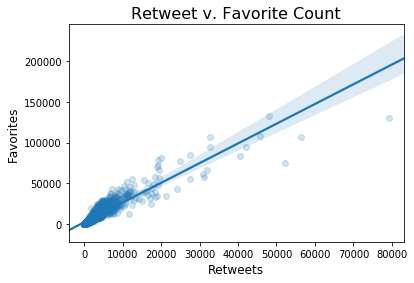

In [74]:
#plot the relationship between favorite count and retweets
sns.regplot(x="retweet_count", y="favorite_count", data=twitter_archive_master, scatter_kws={'alpha':0.2})
plt.title('Retweet v. Favorite Count', size=16)
plt.xlabel('Retweets', size=12)
plt.ylabel('Favorites', size=12)
plt.savefig('retweet-favorite.png');



In [75]:
# the most common stage of dogs
twitter_archive_master['dog_stage'].value_counts()

Unknown           1426
Pupper             168
Doggo               54
Puppo               21
Doggo, Pupper        8
Floofer              7
Doggo, Puppo         1
Doggo, Floofer       1
Name: dog_stage, dtype: int64

In [76]:
ip_clean['prediction'].value_counts()

Dog          1243
Maybe Dog     508
Not Dog       324
Name: prediction, dtype: int64

# conclusion

#### there is a positive correlation between the favourites and retweets.
#### pupper stage is the most common stage
#### about 60% of the images are actually dogs